## Notebook 1 of 2

# Semantic Segmentation Mask Learning from an Aerial Image Dataset captured by a Drone

In [1]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
from collections import defaultdict, OrderedDict
import itertools
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, MaxPooling2D, Conv2D, ZeroPadding2D, BatchNormalization, UpSampling2D, Lambda, concatenate, Flatten, Reshape, Activation
import pydotplus
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow import one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import MeanIoU
import shutil
from tensorflow.python.keras.utils import data_utils

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Processing

In [3]:
height = 480
width = 640
n_class = 23

#### Downloaded Dataset From http://dronedataset.icg.tugraz.at/ to directory "/home/anish/Documents/MLProjects/AerialPhotoPathfinding/", which has been pre-segmented into 23 classes of objects. The Paths of the image are stored in a list.

In [4]:
image_file_path = "/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/"
seg_file_path = "/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/"

img_paths = []

random.seed(42)

for img_name, seg_name in zip(sorted(os.listdir(image_file_path)), sorted(os.listdir(seg_file_path))):
    img_path = os.path.join(image_file_path, img_name)
    seg_path = os.path.join(seg_file_path, seg_name)
    img_paths.append((img_path, seg_path))
    
random.shuffle(img_paths)
# img_paths_train = itertools.cycle(img_paths[:int(0.9*len(img_paths))])
# img_paths_val = itertools.cycle(img_paths[int(0.9*len(img_paths)):])
img_paths_train = img_paths[:int(0.9*len(img_paths))]
img_paths_val = img_paths[int(0.9*len(img_paths)):]

### Needed for the 1st run
#### The Original image Dataset and its Semantic Mask Labels Dataset is Split into Train and Validation folders on the local machine with a split ratio of 90%(361 images) in the Train folder and 10%(41 images) in the Validation folder.

In [5]:
# labels = ["train/data/", "validation/data/"]
# for lbl in labels:
#     os.makedirs(os.path.join(image_file_path, lbl))
#     os.makedirs(os.path.join(seg_file_path, lbl))


# for img_path, mask_path in img_paths_train:
#     dst_dir_img = os.path.join("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/train/data/", 
#                            os.path.basename(img_path))
#     dst_dir_mask = os.path.join("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/train/data/", 
#                            os.path.basename(mask_path))
#     shutil.move(img_path ,dst_dir_img)
#     shutil.move(mask_path ,dst_dir_mask)

# for img_path, mask_path in img_paths_val:
#     dst_dir_img = os.path.join("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/validation/data/", 
#                            os.path.basename(img_path))
#     dst_dir_mask = os.path.join("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/validation/data/", 
#                            os.path.basename(mask_path))
#     shutil.move(img_path,dst_dir_img)
#     shutil.move(mask_path,dst_dir_mask)

In [6]:
dir_paths = []
labels = ["train/", "validation/"]
for lbl in labels:
    dir_paths.append(os.path.join(image_file_path, lbl))
    dir_paths.append(os.path.join(seg_file_path, lbl))
list(dir_paths)

['/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/train/',
 '/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/train/',
 '/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/validation/',
 '/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/validation/']

In [7]:
def ohe_segmented_labels(seg):
    seg = seg[:,:,:,0]
    one_h = one_hot(seg, n_class)
    one_h = one_h.numpy()
    return one_h

#### Images are fed into the ImageDataGenerator and Augmented, and the Semantic mask Labels are One Hot Encoded and paired together with the Original Image and the final training generator and validation generator is created. 

In [8]:
seed = 42
image_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 40,
                                  horizontal_flip = True,
                                  vertical_flip = True)

mask_datagen = ImageDataGenerator(rotation_range = 40,
                                  horizontal_flip = True,
                                  vertical_flip = True)

image_generator = image_datagen.flow_from_directory(dir_paths[0],
                                                   target_size = (height, width),
                                                   batch_size = 2,
                                                    class_mode=None, seed=seed)

mask_generator = mask_datagen.flow_from_directory(dir_paths[1],
                                                   target_size = (240, 320),
                                                   batch_size = 2,
                                                    class_mode=None, seed=seed)


image_datagen_valid = ImageDataGenerator(rescale = 1./255)
mask_datagen_valid = ImageDataGenerator()

img_validation_gen = image_datagen_valid.flow_from_directory(dir_paths[2],
                                                   target_size = (height, width),
                                                   batch_size = 1,
                                                    class_mode=None, seed=seed)
mask_validation_gen = mask_datagen_valid.flow_from_directory(dir_paths[3],
                                                   target_size = (240, 320),
                                                   batch_size = 1,
                                                    class_mode=None, seed=seed)


def dataset_generator(image_gen, mask_gen):
    while True:        
        img = next(image_gen)
        mask = next(mask_gen)
        ohe = ohe_segmented_labels(mask)
        yield img, ohe
        
train_generator = dataset_generator(image_generator, mask_generator)
validation_generator = dataset_generator(img_validation_gen, mask_validation_gen)

Found 360 images belonging to 1 classes.
Found 360 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


## Model
A Unet Model is used with the a pretrained VGG19 Encoder and using Skip connections from the 1st, 2nd, 3rd and 4th block. The Model used looks similar to the below image.

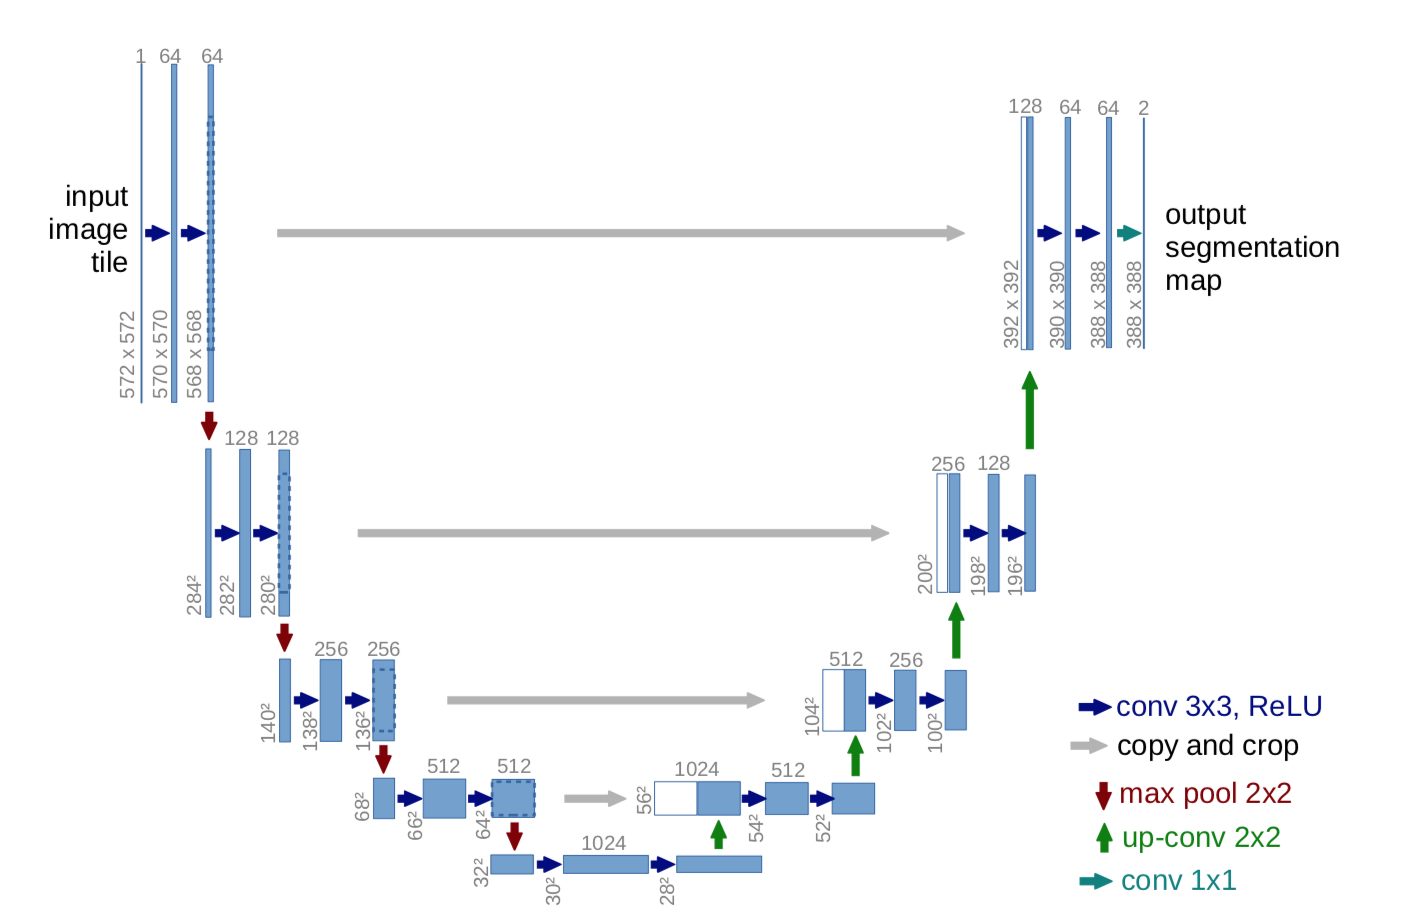

#### Encoder
Since we have a small dataset of about 400 aerial pictures, we use a pretrained conv-net(VGG19) with about 20 million parameters which has been trained on the ImageNet dataset as the Encoder of our Unet Model.

If we simply stack the encoder and decoder layers, there could be loss of low-level information. Hence, the boundaries in segmentation maps produced by the decoder could be inaccurate.

To make up for the information lost, we let the decoder access the low-level features produced by the encoder layers. That is accomplished by skip connections. Intermediate outputs of the encoder are added/concatenated with the inputs to the intermediate layers of the decoder at appropriate positions (denoted by skip1, skip2, skip3, and skip4).

In [ ]:
tf.keras.backend.clear_session()

#ENCODER
#VGG19 model
img_input = Input((height, width, 3), name = 'T0_Image')
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
skip1 = x

    
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
skip2 = x


x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
skip3 = x


x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
skip4 = x


x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
skip5 = x

vgg19_model = Model(inputs = [img_input],
                  outputs = [x])
WEIGHTS_PATH_NO_TOP = ('https://storage.googleapis.com/tensorflow/'
                       'keras-applications/vgg19/'
                       'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')
weights_path = data_utils.get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
          WEIGHTS_PATH_NO_TOP)
vgg19_model.load_weights(weights_path)

#### Decoder
The Encoder base produces a low-resolution tensor containing the high-level information. Taking this low-resolution spatial tensor provided by the Encoder, we have to produce high-resolution segmentation outputs. To do that we add more convolution layers coupled with upsampling layers which increase the size of the spatial tensor. As we increase the resolution, we decrease the number of channels as we are getting back to the low-level information.

In [10]:
#DECODER(U-NET)

d = skip5

d = UpSampling2D((2, 2))(d)
d = concatenate([d, skip4])
d = ZeroPadding2D((1, 1))(d)
d = Conv2D(512, (3, 3), padding='valid', activation='relu')(d)
d = BatchNormalization()(d)

d = UpSampling2D((2, 2))(d)
d = concatenate([d, skip3])
d = ZeroPadding2D((1, 1))(d)
d = Conv2D(256, (3, 3), padding='valid', activation='relu')(d)
d = BatchNormalization()(d)

d = UpSampling2D((2, 2))(d)
d = concatenate([d, skip2])
d = ZeroPadding2D((1, 1))(d)
d = Conv2D(128, (3, 3), padding='valid' , activation='relu')(d)
d = BatchNormalization()(d)

d = UpSampling2D((2, 2))(d)
d = concatenate([d, skip1])
d = ZeroPadding2D((1, 1))(d)
d = Conv2D(64, (3, 3), padding='valid', activation='relu')(d)
d = BatchNormalization()(d)

d = Conv2D(1, kernel_size=(1,1), padding = 'same', activation = 'relu')(d)
d = Conv2D(n_class, (3, 3), padding='same')(d)
d = Activation(('softmax'))(d)
unet_model = Model(inputs = [img_input],
                  outputs = [d])
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T0_Image (InputLayer)           [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 640, 64) 1792        T0_Image[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 640, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 320, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

The convolutional base of VGG19 has about 20 million parameters, which is very large. The Decoder we are adding on top has 7 million parameters.

Before we compile and train our model, a very important thing to do is to freeze the Pretrained Encoder. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the conv layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [11]:
for n in range(1,22):
    unet_model.layers[n].trainable = False

In [12]:
class MyMeanIOU(MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

#### The Unet-Model is trained with the categorical crossentropy loss and the Adam Optimizer and the Pixel Accuracy and Mean IoU is checked.

#### The Model is first trained for 6 epochs with 512 steps per epoch and and learning rate for the adam optimizer is fine tuned.

In [13]:
# lr_schedule = LearningRateScheduler(lambda epoch : 1e-4 * 3**(epoch))
lr_schedule = LearningRateScheduler(lambda epoch : 1e-3 * 2*(epoch))
adam_optimizer = Adam(lr = 1e-3)
IoU = MyMeanIOU(num_classes = n_class)
unet_model.compile(loss = "categorical_crossentropy",
             optimizer = adam_optimizer,
             metrics = ['acc', IoU])

In [14]:
history = unet_model.fit(train_generator, 
                              steps_per_epoch = 512, 
                              epochs = 6,
                              callbacks = [lr_schedule])

Epoch 1/6
512/512 [==============================] - 417s 814ms/step - loss: 3.1409 - acc: 0.0178 - my_mean_iou: 0.0050 - lr: 0.0000e+00
Epoch 2/6
512/512 [==============================] - 418s 816ms/step - loss: 1.9701 - acc: 0.3836 - my_mean_iou: 0.0258 - lr: 0.0020
Epoch 3/6
512/512 [==============================] - 415s 810ms/step - loss: 1.8497 - acc: 0.4108 - my_mean_iou: 0.0305 - lr: 0.0040
Epoch 4/6
512/512 [==============================] - 413s 807ms/step - loss: 1.7837 - acc: 0.4364 - my_mean_iou: 0.0385 - lr: 0.0060
Epoch 5/6
512/512 [==============================] - 427s 834ms/step - loss: 1.7639 - acc: 0.4699 - my_mean_iou: 0.0461 - lr: 0.0080
Epoch 6/6
512/512 [==============================] - 428s 836ms/step - loss: 1.7232 - acc: 0.5022 - my_mean_iou: 0.0509 - lr: 0.0100


(0.001, 0.01, 0.0, 3.0)

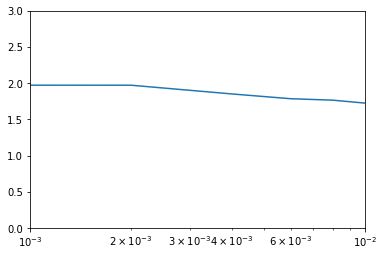

In [16]:
lrs = 1e-3*(2*(np.arange(6)))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-3, 1e-2, 0, 3])

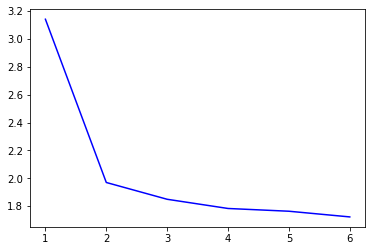

In [17]:
loss = history.history["loss"]
epochs = range(1,7)
plt.plot(epochs, loss, 'b')
plt.show()

We set the learning rate for the Adam Optimizer at 0.006 after a trial run.

In [18]:
adam_optimizer = Adam(lr = 0.006)
unet_model.compile(loss = "categorical_crossentropy",
             optimizer = adam_optimizer,
             metrics = ['acc', IoU])

In [19]:
history = unet_model.fit(train_generator, 
                              steps_per_epoch = 512, 
                              epochs = 20,
                              validation_data = validation_generator,
                              validation_steps = 256)

Epoch 1/20
512/512 [==============================] - 520s 1s/step - loss: 1.6707 - acc: 0.5366 - my_mean_iou: 0.0538 - val_loss: 1.5509 - val_acc: 0.5079 - val_my_mean_iou: 0.0513
Epoch 2/20
512/512 [==============================] - 501s 978ms/step - loss: 1.6675 - acc: 0.5366 - my_mean_iou: 0.0572 - val_loss: 1.5399 - val_acc: 0.5681 - val_my_mean_iou: 0.0604
Epoch 3/20
512/512 [==============================] - 501s 979ms/step - loss: 1.6164 - acc: 0.5586 - my_mean_iou: 0.0605 - val_loss: 1.5075 - val_acc: 0.5577 - val_my_mean_iou: 0.0582
Epoch 4/20
512/512 [==============================] - 512s 999ms/step - loss: 1.6088 - acc: 0.5578 - my_mean_iou: 0.0604 - val_loss: 1.4671 - val_acc: 0.5972 - val_my_mean_iou: 0.0649
Epoch 5/20
512/512 [==============================] - 517s 1s/step - loss: 1.5732 - acc: 0.5539 - my_mean_iou: 0.0570 - val_loss: 1.3371 - val_acc: 0.6089 - val_my_mean_iou: 0.0508
Epoch 6/20
512/512 [==============================] - 515s 1s/step - loss: 1.5848 - ac

#### We achieve a 60-65% validation pixel accuracy and proceed.

In [56]:
# unet_model.save("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/unet_model_1", save_format = "h5")

Plotting our results - 

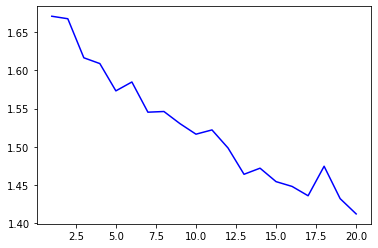

In [31]:
loss = history.history["loss"]
epochs = range(1,21)
plt.plot(epochs, loss, 'b')
plt.show()

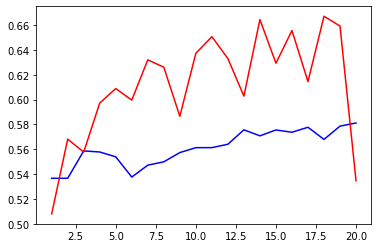

In [33]:
train_acc = history.history["acc"]
val_acc = history.history["val_acc"]
epochs = range(1,21)
plt.plot(epochs, train_acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.show()

### Lets see how well our model is working - 

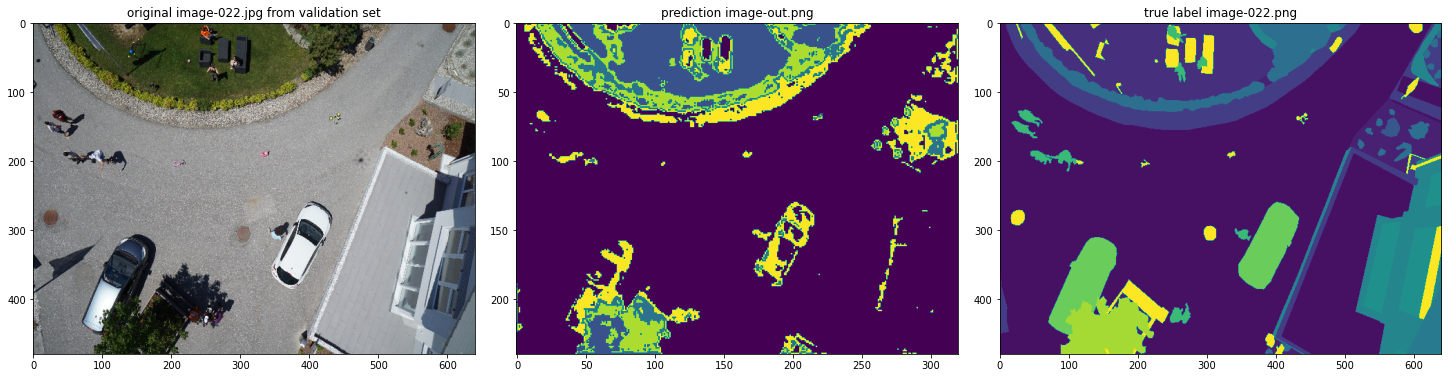

In [23]:
inp_img = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/validation/data/022.jpg", target_size = (height,width)))
inp_img = inp_img.reshape(1, height, width, 3)
pred = unet_model.predict(inp_img/255.)
pred = pred.reshape((240, 320, n_class)).argmax(axis = -1)
fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

inp_img = inp_img.reshape((height, width, 3))
axs[0].imshow(inp_img.astype('uint8'))
axs[0].set_title('original image-022.jpg from validation set')
axs[0].grid(False)

axs[1].imshow(pred)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/validation/data/022.png", target_size = (height,width)))
validation_image = validation_image[:,:,0]
axs[2].imshow(validation_image.astype('uint8'))
axs[2].set_title('true label image-022.png')
axs[2].grid(False)

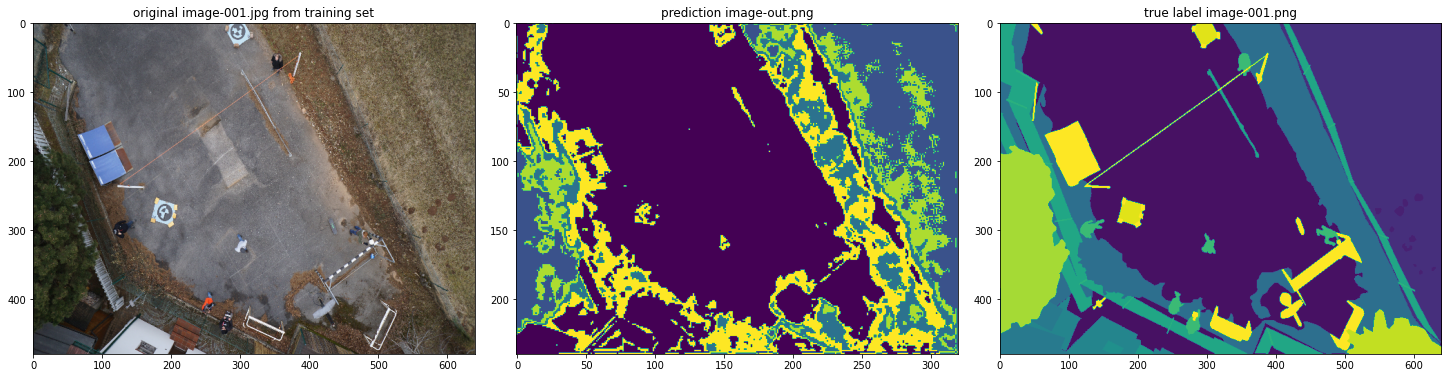

In [24]:
inp_img = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/train/data/001.jpg", target_size = (height,width)))
inp_img = inp_img.reshape(1, height, width, 3)
pred = unet_model.predict(inp_img/255.)
pred = pred.reshape((240, 320, n_class)).argmax(axis = -1)
fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

inp_img = inp_img.reshape((height, width, 3))
axs[0].imshow(inp_img.astype('uint8'))
axs[0].set_title('original image-001.jpg from training set')
axs[0].grid(False)

axs[1].imshow(pred)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/train/data/001.png", target_size = (height,width)))
validation_image = validation_image[:,:,0]
axs[2].imshow(validation_image.astype('uint8'))
axs[2].set_title('true label image-001.png')
axs[2].grid(False)

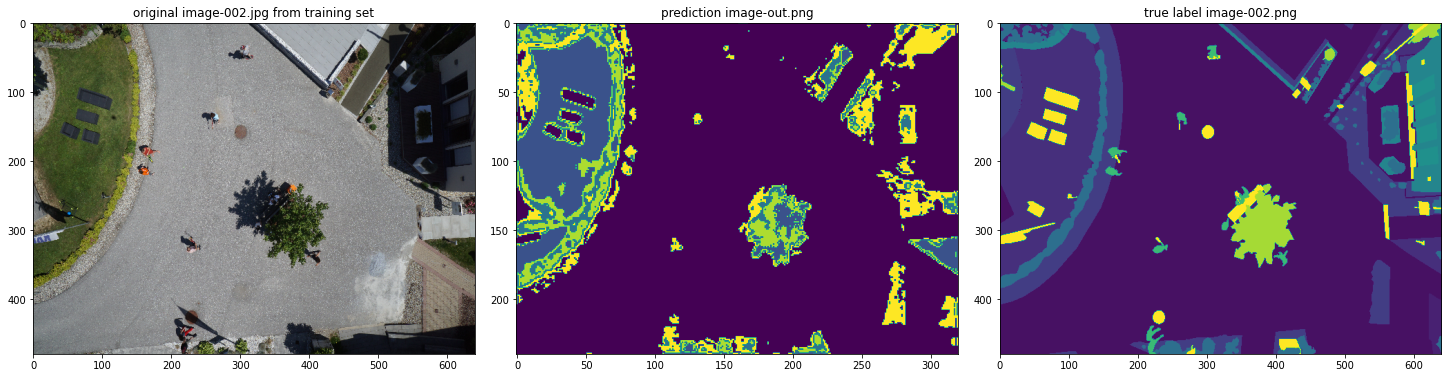

In [25]:
inp_img = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/train/data/002.jpg", target_size = (height,width)))
inp_img = inp_img.reshape(1, height, width, 3)
pred = unet_model.predict(inp_img/255.)
pred = pred.reshape((240, 320, n_class)).argmax(axis = -1)
fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

inp_img = inp_img.reshape((height, width, 3))
axs[0].imshow(inp_img.astype('uint8'))
axs[0].set_title('original image-002.jpg from train set')
axs[0].grid(False)

axs[1].imshow(pred)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/train/data/002.png", target_size = (height,width)))
validation_image = validation_image[:,:,0]
axs[2].imshow(validation_image.astype('uint8'))
axs[2].set_title('true label image-002.png')
axs[2].grid(False)

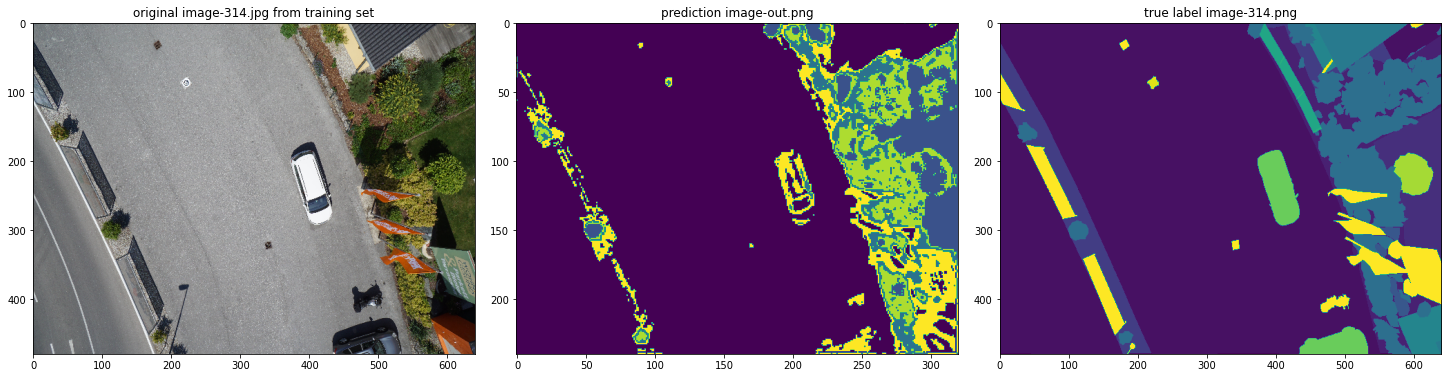

In [28]:
inp_img = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/validation/data/314.jpg", target_size = (height,width)))
inp_img = inp_img.reshape(1, height, width, 3)
pred = unet_model.predict(inp_img/255.)
pred = pred.reshape((240, 320, n_class)).argmax(axis = -1)
fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

inp_img = inp_img.reshape((height, width, 3))
axs[0].imshow(inp_img.astype('uint8'))
axs[0].set_title('original image-314.jpg from validation set')
axs[0].grid(False)

axs[1].imshow(pred)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/validation/data/314.png", target_size = (height,width)))
validation_image = validation_image[:,:,0]
axs[2].imshow(validation_image.astype('uint8'))
axs[2].set_title('true label image-314.png')
axs[2].grid(False)

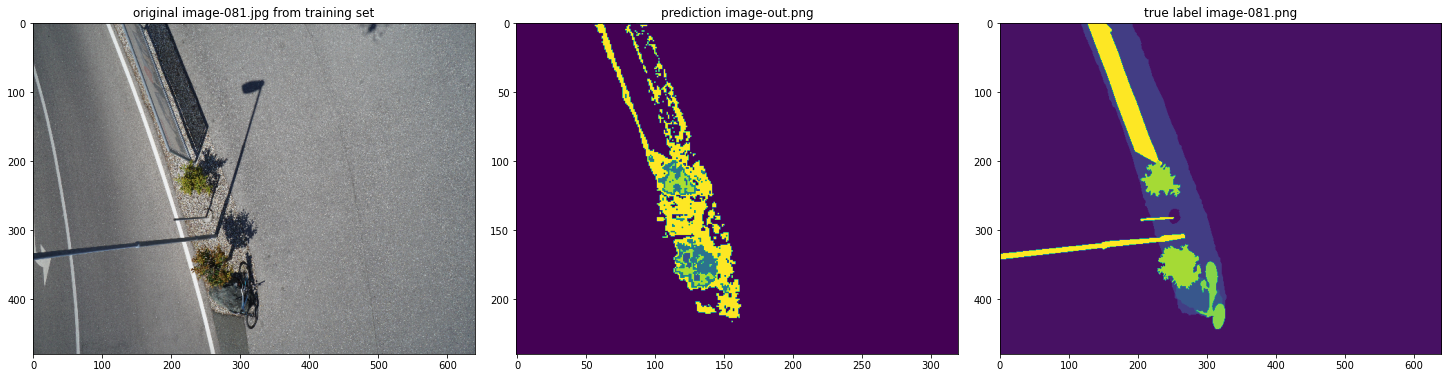

In [29]:
inp_img = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/train/data/081.jpg", target_size = (height,width)))
inp_img = inp_img.reshape(1, height, width, 3)
pred = unet_model.predict(inp_img/255.)
pred = pred.reshape((240, 320, n_class)).argmax(axis = -1)
fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

inp_img = inp_img.reshape((height, width, 3))
axs[0].imshow(inp_img.astype('uint8'))
axs[0].set_title('original image-081.jpg from training set')
axs[0].grid(False)

axs[1].imshow(pred)
axs[1].set_title('prediction image-out.png')
axs[1].grid(False)

validation_image = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/label_images_semantic/train/data/081.png", target_size = (height,width)))
validation_image = validation_image[:,:,0]
axs[2].imshow(validation_image.astype('uint8'))
axs[2].set_title('true label image-081.png')
axs[2].grid(False)

#### We train the model one last time on the validation set of images and proceed.

In [75]:
history = unet_model.fit(validation_generator, 
                              steps_per_epoch = 512, 
                              epochs = 4)

Epoch 1/4
512/512 [==============================] - 185s 361ms/step - loss: 0.9786 - acc: 0.7082 - my_mean_iou: 0.0979
Epoch 2/4
512/512 [==============================] - 185s 360ms/step - loss: 0.9211 - acc: 0.7324 - my_mean_iou: 0.1118
Epoch 3/4
512/512 [==============================] - 184s 359ms/step - loss: 0.9114 - acc: 0.7379 - my_mean_iou: 0.1149
Epoch 4/4
512/512 [==============================] - 183s 358ms/step - loss: 0.8649 - acc: 0.7555 - my_mean_iou: 0.1227


#### We've reached a decent level of performance and we can proceed onto the next notebook of plotting a path through the obstacles.

In [76]:
unet_model.save_weights("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/unet_model_weights")

In [106]:
unet_model.save("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/unet_model",  save_format = 'tf')

INFO:tensorflow:Assets written to: /home/anish/Documents/MLProjects/AerialPhotoPathfinding/unet_model/assets
